In [31]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
# Set random seeds

sampling_seed = np.random.seed(13)
train_test_seed = np.random.seed(69)
cv_seed = np.random.seed(37)
model_seed = np.random.seed(73)
np.random.seed(42) # set default seed value

In [32]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df`
"""
tic = time.time()
full_df = bq.Client().query(query).to_dataframe()
toc = time.time()
print("Data took %d seconds to fetch" % (toc-tic))
full_df.head()

Data took 436 seconds to fetch


,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor_50,count_neighbor_100,count_neighbor_250,count_neighbor_500,state_name
0,269863879,8.65,55.925475,30.536030,11.096709,NaN,None,NL,None,1967.0,12,0.868155,11.166322,82.0,180.0,1174.0,1174.0,South Holland
1,269315362,2.54,8.187290,11.452042,4.058087,NaN,None,NL,None,1980.0,5,0.885711,6.770144,80.0,190.0,812.0,812.0,South Holland
2,253319369,2.73,9.480299,12.582101,4.541754,NaN,None,NL,None,1973.0,5,0.867487,7.170471,102.0,260.0,882.0,882.0,South Holland
3,253600994,5.77,45.829649,28.168260,10.339362,NaN,None,NL,None,1989.0,5,0.851958,10.826134,78.0,289.0,1012.0,1012.0,South Holland
4,273607660,7.41,49.166540,28.140997,9.993203,NaN,None,NL,None,1950.0,6,0.883284,10.627279,80.0,238.0,1024.0,1024.0,South Holland


In [33]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df_tbl`
"""

tic = time.time()
full_tbl = bq.Client().query(query).to_dataframe()
toc = time.time()
print("Data took %d seconds to fetch" % (toc-tic))
full_tbl.head()

Data took 216 seconds to fetch


,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor_50,count_neighbor_100,count_neighbor_250,count_neighbor_500,state_name
0,286928757,8.33,47.297478,32.634087,12.566106,NaN,None,NL,None,1935.0,7,0.747055,12.444056,102.0,248.0,1048.0,1048.0,South Holland
1,266184602,3.96,19.942784,17.868733,6.324063,NaN,None,NL,None,1961.0,6,0.885939,8.455656,98.0,277.0,1087.0,1087.0,South Holland
2,268018495,8.07,59.201948,38.242703,14.414031,NaN,None,NL,None,1950.0,14,0.713221,13.786835,94.0,271.0,758.0,758.0,South Holland
3,274531112,3.04,6.438699,10.277755,3.683353,NaN,None,NL,None,1921.0,5,0.875197,6.452065,84.0,241.0,1428.0,1428.0,South Holland
4,265328346,8.42,72.116286,40.884519,15.033658,NaN,None,NL,None,1930.0,19,0.736313,14.029770,82.0,262.0,1107.0,1107.0,South Holland


In [5]:
full_df.set_index('osm_way_id', inplace=True)

In [6]:
full_df.shape

(1087325, 17)

In [7]:
full_df["city"] = full_df["city"].astype("category")
full_df["state_name"] = full_df["state_name"].astype("category")
full_df["country"] = full_df["country"].astype("category")
full_df["postcode"] = full_df["postcode"].astype("category")
# df["year"] = df["year"].astype(float).astype("Int64")
# df["count_vertices"] = df["count_vertices"].astype(float).astype("Int64")
# df["count_neighbor"] = df["count_neighbor"].astype(float).astype("Int64")
# df["building_levels"] = df["building_levels"].astype(float).astype("Int64")
full_df.dtypes

bldg_height            float64
area                   float64
perimeter              float64
length                 float64
building_levels        float64
city                  category
country               category
postcode              category
year                   float64
count_vertices           int64
compactness            float64
complexity             float64
count_neighbor_50      float64
count_neighbor_100     float64
count_neighbor_250     float64
count_neighbor_500     float64
state_name            category
dtype: object

In [8]:
full_df.isna().sum()

bldg_height                 0
area                        0
perimeter                   0
length                      0
building_levels       1078855
city                  1086473
country                     0
postcode              1086509
year                       56
count_vertices              0
compactness                 0
complexity                  0
count_neighbor_50       14245
count_neighbor_100       1993
count_neighbor_250        143
count_neighbor_500        143
state_name                  0
dtype: int64

In [9]:
label_col = ["bldg_height"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor_500", "count_neighbor_250", "count_neighbor_100", "count_neighbor_50"]
# cat_cols = ["city", "postcode"]
cat_cols = [col for col in full_df.columns if col not in (num_cols + label_col)]

In [10]:
corr_df = full_df[num_cols+label_col]
corr_df.head()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor_500,count_neighbor_250,count_neighbor_100,count_neighbor_50,bldg_height
osm_way_id,,,,,,,,,,,,,
286928757,47.297478,32.634087,12.566106,NaN,1935.0,7,0.747055,12.444056,1048.0,1048.0,248.0,102.0,8.33
266184602,19.942784,17.868733,6.324063,NaN,1961.0,6,0.885939,8.455656,1087.0,1087.0,277.0,98.0,3.96
268018495,59.201948,38.242703,14.414031,NaN,1950.0,14,0.713221,13.786835,758.0,758.0,271.0,94.0,8.07
274531112,6.438699,10.277755,3.683353,NaN,1921.0,5,0.875197,6.452065,1428.0,1428.0,241.0,84.0,3.04
265328346,72.116286,40.884519,15.033658,NaN,1930.0,19,0.736313,14.029770,1107.0,1107.0,262.0,82.0,8.42


In [11]:
corr_df.isna().sum()

area                        0
perimeter                   0
length                      0
building_levels       1078855
year                       56
count_vertices              0
compactness                 0
complexity                  0
count_neighbor_500        143
count_neighbor_250        143
count_neighbor_100       1993
count_neighbor_50       14245
bldg_height                 0
dtype: int64

In [12]:
corr_df['year'] = corr_df['year'].fillna(corr_df['year'].mean())
corr_df['building_levels'] = corr_df['building_levels'].fillna(1)
corr_df['count_neighbor_500'] = corr_df['count_neighbor_500'].fillna(0)
corr_df['count_neighbor_250'] = corr_df['count_neighbor_250'].fillna(0)
corr_df['count_neighbor_100'] = corr_df['count_neighbor_100'].fillna(0)
corr_df['count_neighbor_50'] = corr_df['count_neighbor_50'].fillna(0)

In [13]:
corr_df.isna().sum()

area                  0
perimeter             0
length                0
building_levels       0
year                  0
count_vertices        0
compactness           0
complexity            0
count_neighbor_500    0
count_neighbor_250    0
count_neighbor_100    0
count_neighbor_50     0
bldg_height           0
dtype: int64

In [14]:
corr_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor_500,count_neighbor_250,count_neighbor_100,count_neighbor_50,bldg_height
count,1.087325e+06,1.087325e+06,1.087325e+06,1.087325e+06,1.087325e+06,1.087325e+06,1.087325e+06,1.087325e+06,1.087325e+06,1.087325e+06,1.087325e+06,1.087325e+06,1.087325e+06
mean,1.832892e+02,4.415689e+01,1.599098e+01,1.010974e+00,1.965745e+03,8.277917e+00,8.033141e-01,1.340871e+01,6.020176e+02,6.020176e+02,1.267818e+02,3.746766e+01,8.207537e+00
std,1.461076e+03,4.927989e+01,1.705065e+01,2.534223e-01,4.010506e+01,6.025573e+00,7.527427e-02,5.183715e+00,3.148623e+02,3.148623e+02,7.235468e+01,2.291253e+01,3.081628e+00
min,2.650812e-04,8.183244e-02,3.404680e-02,-4.000000e+00,1.133000e+03,4.000000e+00,2.828082e-02,6.413288e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,4.908679e+01,2.930771e+01,1.066329e+01,1.000000e+00,1.951000e+03,5.000000e+00,7.623299e-01,1.101824e+01,3.930000e+02,3.930000e+02,7.300000e+01,1.900000e+01,6.760000e+00
50%,5.981806e+01,3.462437e+01,1.280913e+01,1.000000e+00,1.974000e+03,7.000000e+00,8.258442e-01,1.233276e+01,6.160000e+02,6.160000e+02,1.280000e+02,3.700000e+01,8.410000e+00
75%,9.230109e+01,4.418561e+01,1.611501e+01,1.000000e+00,1.990000e+03,9.000000e+00,8.607019e-01,1.437489e+01,8.170000e+02,8.170000e+02,1.770000e+02,5.300000e+01,9.220000e+00
max,2.562055e+05,3.925806e+03,9.652139e+02,4.400000e+01,2.020000e+03,7.930000e+02,9.999208e-01,2.340868e+02,2.135000e+03,2.135000e+03,4.900000e+02,1.780000e+02,1.781500e+02


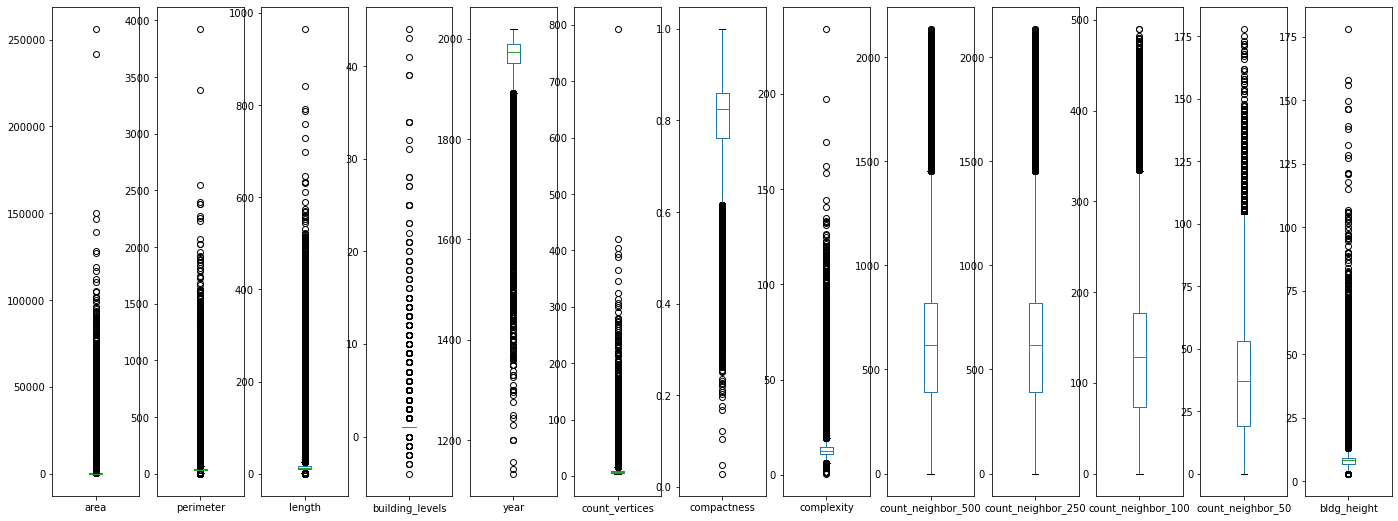

In [15]:
corr_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('feature_selection/south_holland_corr_basic_distribution.png')

In [16]:
corr = corr_df.corr()
corr

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor_500,count_neighbor_250,count_neighbor_100,count_neighbor_50,bldg_height
area,1.000000,0.781608,0.772277,0.012047,0.037202,0.186012,-0.072395,0.527244,-0.120445,-0.120445,-0.128078,-0.129163,0.037670
perimeter,0.781608,1.000000,0.983389,0.041752,0.029446,0.491693,-0.351838,0.917116,-0.250671,-0.250671,-0.300501,-0.325909,0.196954
length,0.772277,0.983389,1.000000,0.045300,0.025414,0.434970,-0.353231,0.906144,-0.253311,-0.253311,-0.302372,-0.326677,0.197281
building_levels,0.012047,0.041752,0.045300,1.000000,0.007248,0.035459,-0.008670,0.048807,-0.024763,-0.024763,-0.029891,-0.030615,0.206374
year,0.037202,0.029446,0.025414,0.007248,1.000000,-0.046042,0.111379,-0.007520,-0.088759,-0.088759,-0.044777,-0.022122,-0.078089
count_vertices,0.186012,0.491693,0.434970,0.035459,-0.046042,1.000000,-0.496259,0.605442,-0.122415,-0.122415,-0.201709,-0.251390,0.251058
compactness,-0.072395,-0.351838,-0.353231,-0.008670,0.111379,-0.496259,1.000000,-0.589099,0.071451,0.071451,0.146910,0.198057,-0.142211
complexity,0.527244,0.917116,0.906144,0.048807,-0.007520,0.605442,-0.589099,1.000000,-0.284952,-0.284952,-0.363225,-0.407827,0.283451
count_neighbor_500,-0.120445,-0.250671,-0.253311,-0.024763,-0.088759,-0.122415,0.071451,-0.284952,1.000000,1.000000,0.819244,0.684968,0.071073
count_neighbor_250,-0.120445,-0.250671,-0.253311,-0.024763,-0.088759,-0.122415,0.071451,-0.284952,1.000000,1.000000,0.819244,0.684968,0.071073


In [17]:
import seaborn as sns

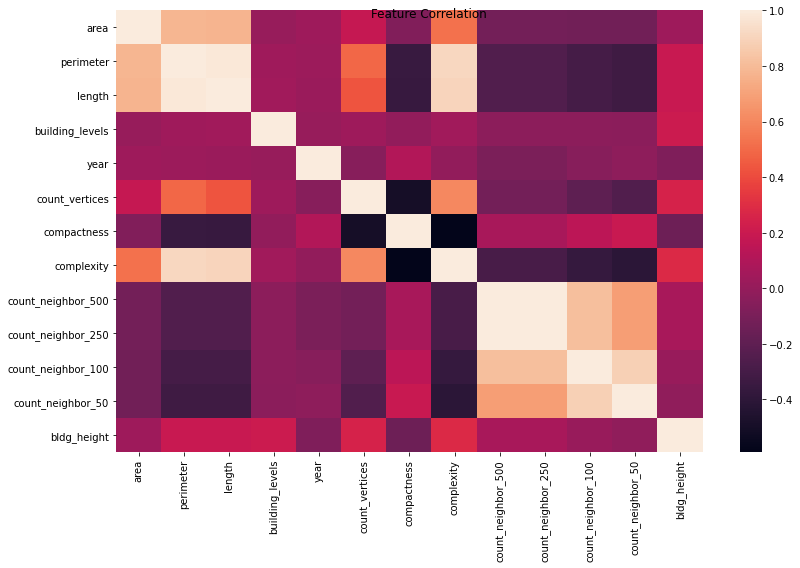

In [18]:

fig = plt.figure(figsize=(12,8))
fig.suptitle('Feature Correlation')
sns.heatmap(corr)
plt.savefig('feature_selection/south_holland_corr_heatmap.png', dpi=300)
plt.tight_layout()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [20]:
sample_df = corr_df.sample(frac=0.1, random_state=sampling_seed)
sample_df.head()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor_500,count_neighbor_250,count_neighbor_100,count_neighbor_50,bldg_height
osm_way_id,,,,,,,,,,,,,
471203109,40.407158,26.959208,10.054762,1.0,2013.0,6,0.835847,10.692827,494.0,494.0,63.0,39.0,6.96
267797642,61.276666,33.347727,12.502408,1.0,1930.0,10,0.832121,11.919072,629.0,629.0,162.0,49.0,10.09
271643970,1237.735029,161.839184,57.730740,1.0,1979.0,15,0.770611,27.285176,30.0,30.0,4.0,1.0,4.03
277888586,10.489740,13.295411,4.825477,1.0,1901.0,6,0.863546,7.387722,63.0,63.0,11.0,3.0,3.03
283190722,127.628877,52.632147,18.046315,1.0,1925.0,9,0.760901,15.658994,227.0,227.0,35.0,15.0,7.55


In [21]:
X = corr_df.drop('bldg_height', axis=1)    # drop cat_cols since can't evaluate non-numeric
y = corr_df['bldg_height']

X, y

(                 area  perimeter     length  building_levels    year  \
 osm_way_id                                                             
 286928757   47.297478  32.634087  12.566106              1.0  1935.0   
 266184602   19.942784  17.868733   6.324063              1.0  1961.0   
 268018495   59.201948  38.242703  14.414031              1.0  1950.0   
 274531112    6.438699  10.277755   3.683353              1.0  1921.0   
 265328346   72.116286  40.884519  15.033658              1.0  1930.0   
 ...               ...        ...        ...              ...     ...   
 269940376    9.032767  12.077720   4.296990              1.0  1952.0   
 287840689   13.906937  14.961355   5.320216              1.0  1948.0   
 281113174   47.270092  27.652140   9.845692              1.0  1966.0   
 289341052   44.333553  26.798827   9.537284              1.0  1948.0   
 271444621   53.332596  29.909385  10.933229              1.0  1948.0   
 
             count_vertices  compactness  complex

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=train_test_seed)

In [23]:
# feature selection function
def select_features(score_function, X_train, y_train, X_test, k):
	# configure to select all features
	fs = SelectKBest(score_func=score_function, k=k)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

Feature 0 - area: 1164.812531
Feature 1 - perimeter: 34672.952696
Feature 2 - length: 34852.815979
Feature 3 - building_levels: 42176.154122
Feature 4 - year: 5267.913855
Feature 5 - count_vertices: 58931.328279
Feature 6 - compactness: 17834.646667
Feature 7 - complexity: 75679.020405
Feature 8 - count_neighbor_500: 4308.274008
Feature 9 - count_neighbor_250: 4308.274008
Feature 10 - count_neighbor_100: 219.510248
Feature 11 - count_neighbor_50: 191.584348


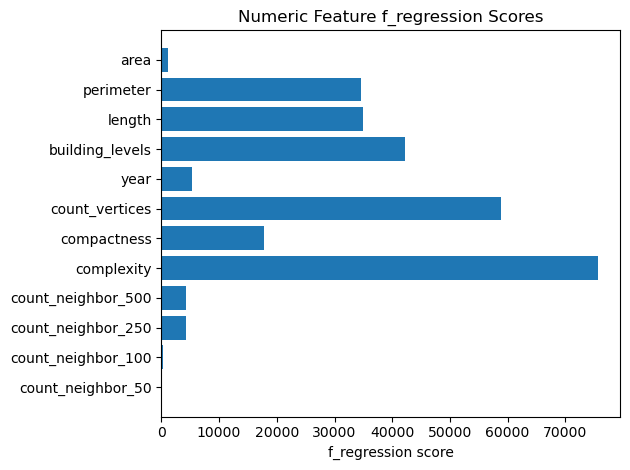

In [24]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(f_regression, X_train, y_train, X_test, 'all')
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d - %s: %f' % (i, num_cols[i], fs.scores_[i]))
# plot the scores
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(num_cols, fs.scores_)
y_pos = np.arange(len(num_cols))
ax.set_yticks(y_pos)
ax.set_yticklabels(num_cols)
ax.invert_yaxis()
ax.set_xlabel('f_regression score')
ax.set_title('Numeric Feature f_regression Scores')
plt.tight_layout()
plt.savefig('feature_selection/south_holland_corr_f_regression.png')
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [25]:
sample_df.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor_500,count_neighbor_250,count_neighbor_100,count_neighbor_50,bldg_height
count,108732.000000,108732.000000,108732.000000,108732.000000,108732.000000,108732.000000,108732.000000,108732.000000,108732.000000,108732.000000,108732.000000,108732.000000,108732.000000
mean,182.733593,44.219794,16.014154,1.011147,1965.742734,8.287680,0.803171,13.416054,602.125602,602.125602,126.736131,37.366571,8.213640
std,1427.901147,49.619988,17.118336,0.275496,39.938873,6.063407,0.075150,5.209410,314.550161,314.550161,72.347473,22.854283,3.132226
min,0.010735,0.414524,0.146975,0.000000,1337.000000,4.000000,0.264928,1.287812,0.000000,0.000000,0.000000,0.000000,3.000000
25%,49.108051,29.333602,10.675360,1.000000,1951.000000,5.000000,0.761971,11.024612,394.000000,394.000000,73.000000,19.000000,6.760000
50%,59.996885,34.685128,12.830461,1.000000,1974.000000,7.000000,0.825607,12.353514,615.000000,615.000000,127.000000,37.000000,8.410000
75%,92.489046,44.161721,16.109287,1.000000,1990.000000,9.000000,0.860513,14.374246,816.000000,816.000000,177.000000,53.000000,9.220000
max,127111.022810,1955.258259,646.295508,39.000000,2020.000000,304.000000,0.999705,131.100502,2098.000000,2098.000000,490.000000,144.000000,146.480000


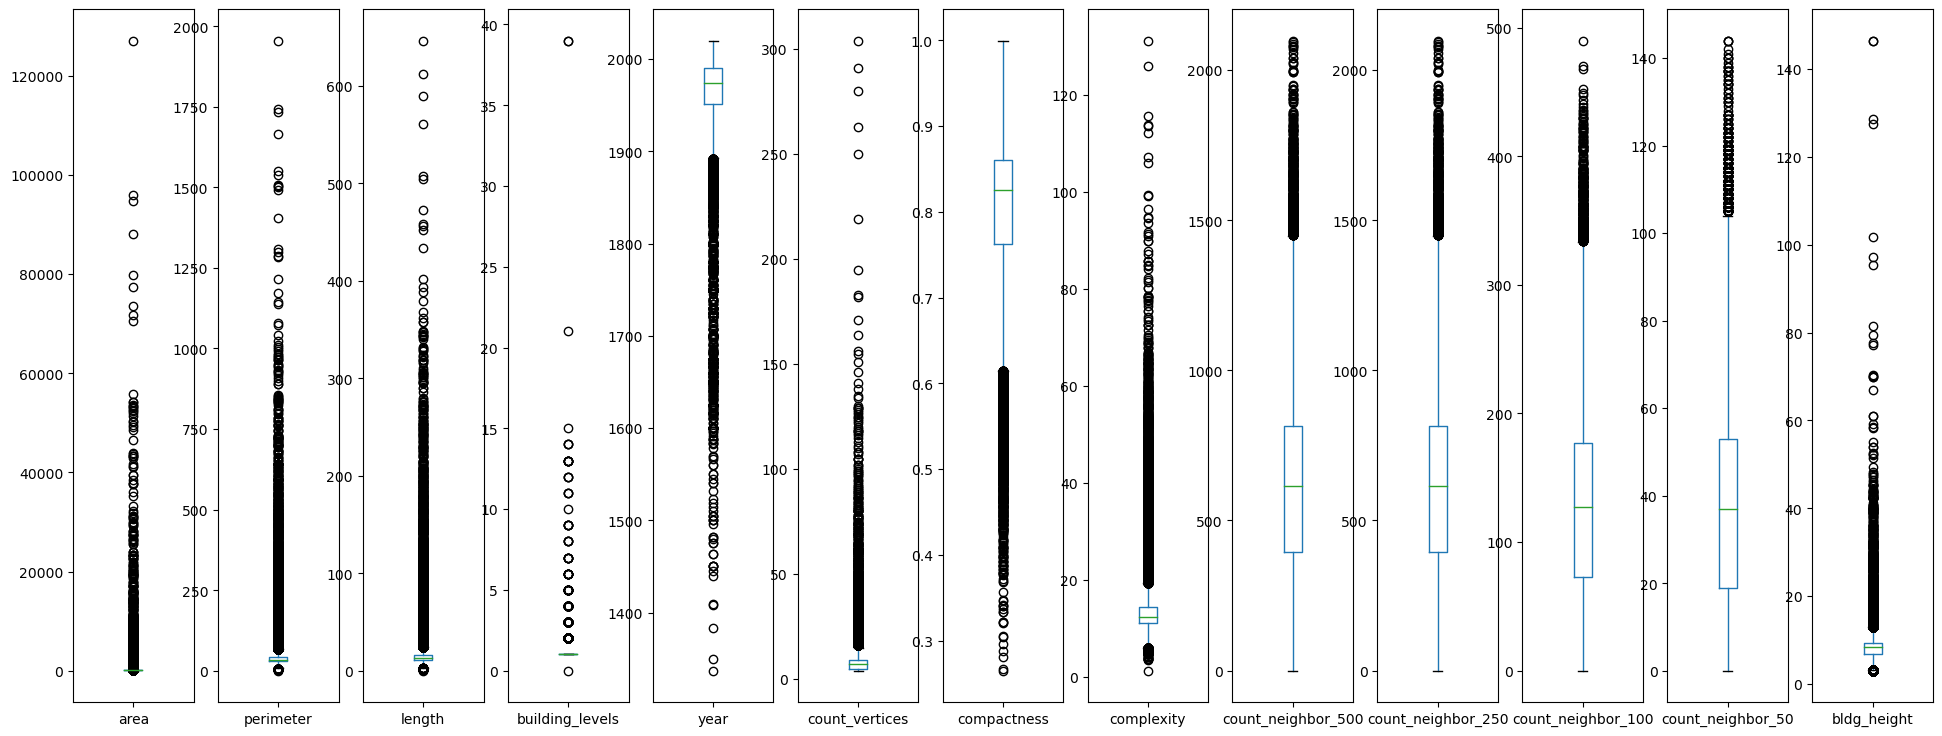

In [26]:
sample_df.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('feature_selection/south_holland_10prct_basic_distribution.png')
plt.savefig('exploratory_10prct/south_holland_basic_distribution.png')

In [27]:
X = sample_df.drop('bldg_height', axis=1)   # drop cat_cols since can't evaluate non-numeric
y = sample_df['bldg_height']

X, y

(                   area   perimeter     length  building_levels    year  \
 osm_way_id                                                                
 471203109     40.407158   26.959208  10.054762              1.0  2013.0   
 267797642     61.276666   33.347727  12.502408              1.0  1930.0   
 271643970   1237.735029  161.839184  57.730740              1.0  1979.0   
 277888586     10.489740   13.295411   4.825477              1.0  1901.0   
 283190722    127.628877   52.632147  18.046315              1.0  1925.0   
 ...                 ...         ...        ...              ...     ...   
 271216726     59.940454   35.053742  12.615633              1.0  1964.0   
 254786193     69.824550   36.693913  14.049135              1.0  2007.0   
 271486074     52.097881   30.661757  11.451658              1.0  1974.0   
 269721447     70.451113   34.697767  12.622134              1.0  1913.0   
 290424227     51.116074   30.206009  11.221263              1.0  1997.0   
 
          

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=train_test_seed)

Feature 0 - area: 133.618471
Feature 1 - perimeter: 3411.893372
Feature 2 - length: 3473.932652
Feature 3 - building_levels: 4303.857581
Feature 4 - year: 478.070950
Feature 5 - count_vertices: 5871.730786
Feature 6 - compactness: 1708.397063
Feature 7 - complexity: 7321.802554
Feature 8 - count_neighbor_500: 440.545415
Feature 9 - count_neighbor_250: 440.545415
Feature 10 - count_neighbor_100: 24.002057
Feature 11 - count_neighbor_50: 18.051650


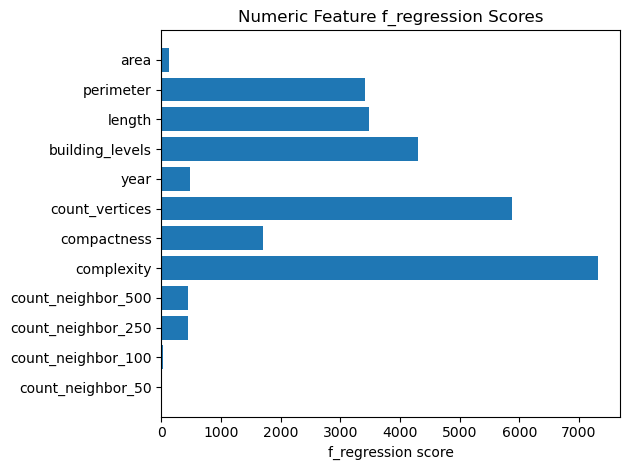

In [29]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(f_regression, X_train, y_train, X_test, 'all')
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d - %s: %f' % (i, num_cols[i], fs.scores_[i]))
# plot the scores
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(num_cols, fs.scores_)
y_pos = np.arange(len(num_cols))
ax.set_yticks(y_pos)
ax.set_yticklabels(num_cols)
ax.invert_yaxis()
ax.set_xlabel('f_regression score')
ax.set_title('Numeric Feature f_regression Scores')
plt.tight_layout()
plt.savefig('feature_selection/south_holland_10prct_corr_f_regression.png')
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

Feature 0 - area: 0.305954
Feature 1 - perimeter: 0.300258
Feature 2 - length: 0.299373
Feature 3 - building_levels: 0.004988
Feature 4 - year: 0.216202
Feature 5 - count_vertices: 0.063557
Feature 6 - compactness: 0.078540
Feature 7 - complexity: 0.286565
Feature 8 - count_neighbor_500: 0.077971
Feature 9 - count_neighbor_250: 0.077751
Feature 10 - count_neighbor_100: 0.094506
Feature 11 - count_neighbor_50: 0.100033


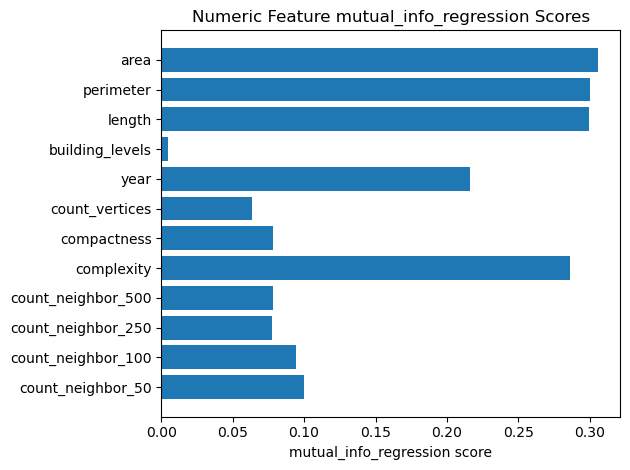

In [30]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(mutual_info_regression, X_train, y_train, X_test, 'all')
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d - %s: %f' % (i, num_cols[i], fs.scores_[i]))
# plot the scores
plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(num_cols, fs.scores_)
y_pos = np.arange(len(num_cols))
ax.set_yticks(y_pos)
ax.set_yticklabels(num_cols)
ax.invert_yaxis()
ax.set_xlabel('mutual_info_regression score')
ax.set_title('Numeric Feature mutual_info_regression Scores')
plt.tight_layout()
plt.savefig('feature_selection/south_holland_10prct_mutual_information_regression.png')
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [ ]:
# num_df = df[num_cols].fillna(df[num_cols].mean())
# num_df.isna().sum()